In [114]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import sklearn.neural_network
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import seaborn as sns

## Read Data

In [115]:
def read_csv(filepath):
    '''
    '''
    return pd.read_csv(filepath)

In [116]:
main = read_csv('credit-data.csv')

## Pre-Process Data

In [88]:
def replace_na_with_mean(df, var):
    '''
    Replaces all the NA's in a given column with the mean of that column.
    
    Input:
        df (pandas dataframe): original dataframe
        var (string): column containing NA values
    '''
    mean_var = main[var].mean()
    main[var].fillna(mean_var, inplace=True)

In [89]:
def fill_missing_with_mean(df):
    '''
    Takes a dataframe and replaces all NA's in all columns with the mean.
    
    Input:
        df (pandas dataframe): original dataframe
    '''
    na_cols = list(main.loc[:, main.isna().any()].columns)
    for col in na_cols:
        replace_na_with_mean(df, col) 
        
    return main

In [122]:
def na_cols(df):
    '''
    Produces a list of columns in the data frame that have N/A values.
    
    Input:
        df (data frame): data frame of interest
        
    Output:
        list of columns that contain N/A's
    '''
    
    return list(main.loc[:, main.isna().any()].columns)

In [123]:
na_cols(main)

['MonthlyIncome', 'NumberOfDependents']

In [118]:
main['NumberOfDependents'].describe()

count    39979.000000
mean         0.773231
std          1.121269
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         13.000000
Name: NumberOfDependents, dtype: float64

In [119]:
main['MonthlyIncome'].describe()

count    3.304200e+04
mean     6.578996e+03
std      1.344683e+04
min      0.000000e+00
25%      3.333000e+03
50%      5.250000e+03
75%      8.055750e+03
max      1.794060e+06
Name: MonthlyIncome, dtype: float64

In [90]:
main = fill_missing_with_mean(main)

# The columns that contain N/As are NumberOfDependents and MonthlyIncome. These are both demographic factors for which
# economists and sociologists often look at the mean as representative of the sample as a whole. Therefore
# in order to facilitate analysis without removing data points the mean is used in this analysis.

In [91]:
# removes person ID and zip code, values you cannot take statistical measures of 

relevant = main[['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines',
       'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']]


In [92]:
# removed ages where there is not continous or sufficient data 

by_age = relevant.groupby('age').mean()
by_age = by_age.drop([103, 109, 96, 97, 98, 99])

## Explore Data

In [103]:
def plot_line_graph(df, var, title, xlabel, ylabel):
    x = list(df.index.values)
    y = list(df[var].values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x,y)
    plt.show()

#### Correlation Heatmap

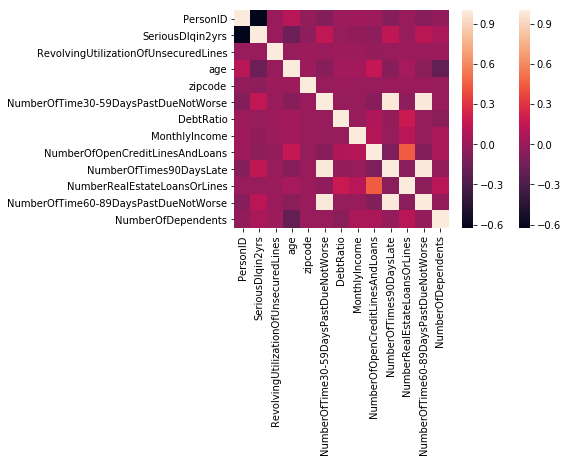

In [107]:
corr = main.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

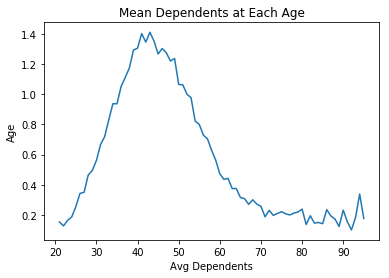

In [108]:
plot_line_graph(by_age, 'NumberOfDependents', 'Mean Dependents at Each Age', 'Avg Dependents', 'Age')

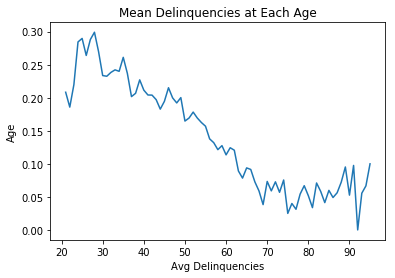

In [109]:
plot_line_graph(by_age, 'SeriousDlqin2yrs', 'Mean Delinquencies at Each Age', 'Avg Delinquencies', 'Age')

## Generate Features/Predictors

In [72]:
def add_dummy_variable(df, var, dummy_var, lambda_eq):
    df[dummy_var] = df[var].apply(lambda_eq)

In [73]:
def add_discrete_variable(df, var, discrete_var, num_categories):
    df[discrete_var] = pd.cut(df[var], num_categories)

In [ ]:
main_plus = main

In [83]:
add_dummy_variable(main_plus, 'MonthlyIncome', 'Impoverished', lambda x: x < 23550)

In [84]:
not_impoverished = main_plus.groupby('Impoverished').count().PersonID[0]
impoverished = main_plus.groupby('Impoverished').count().PersonID[1]
total = main.shape[0]
percent_in_poverty = str(round((impoverished/total)*100))
print(percent_in_poverty + "% of the people in this study have an income below the poverty line for a family of 4.")

99.0% of the people in this study have an income below the poverty line for a family of 4.


In [79]:
add_discrete_variable(main_plus, 'NumberOfTimes90DaysLate', 'Discrete NumberOfTimes90DaysLate', 200)

## Build Classifier

In [38]:
def divide_df(df, var, test_size = 0.3):
    # var must be a string
    X = df
    Y = df[var]
    test_size = 0.3
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    
    return x_train, x_test, y_train, y_test

In [55]:
x_train, x_test, y_train, y_test = divide_df(main, 'SeriousDlqin2yrs', test_size = 0.3)

#### K Nearest Neighbors

In [56]:
knn = KNeighborsClassifier(n_neighbors=10, metric='minkowski', metric_params={'p': 3})
knn.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  """Entry point for launching an IPython kernel.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params={'p': 3}, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

#### Neural Net

In [82]:
nn = sklearn.neural_network.MLPClassifier()
nn.fit(x_train, y_train)
print("The number of hidden layers is", nn.n_layers_ - 2)

The number of hidden layers is 1


## Evaluate Classifier

In [111]:
def evaluate_classifier(classifier, x_train, y_train, x_test, y_test):
    print('Training: ')
    print(classifier.score(x_train, y_train))
    print('Testing: ')
    print(classifier.score(x_test, y_test))

In [112]:
# K Nearest Neighbors

evaluate_classifier(knn, x_train, y_train, x_test, y_test)

Training: 
0.943227334471
Testing: 
0.943193823649


In [113]:
# Neural Net

evaluate_classifier(nn, x_train, y_train, x_test, y_test)

Training: 
0.909686182996
Testing: 
0.910686712718
